# Various AutoEncoders in DeepLearning <img src="https://d1nhio0ox7pgb.cloudfront.net/_img/g_collection_png/standard/512x512/fire.png"  width="25" height="25">

Autoencoders are a type of neural network which generates an “n-layer” coding of the given input and attempts to reconstruct the input using the code generated. This Neural Network architecture is divided into the encoder structure, the decoder structure, and the latent space, also known as the “bottleneck”. To learn the data representations of the input, the network is trained using Unsupervised data. These compressed, data representations go through a decoding process wherein which the input is reconstructed. An autoencoder is a regression task that models an identity function.

##### AutoEncoders are used to find the most important features

## 1) Undercomplete Autoencoders
Undercomplete autoencoder takes in an image and tries to predict the same image as output, thus reconstructing the image from the compressed bottleneck region.

Undercomplete autoencoders are truly unsupervised as they do not take any form of label, the target being the same as the input.

The primary use of autoencoders like such is the generation of the latent space or the bottleneck, which forms a compressed substitute of the input data and can be easily decompressed back with the help of the network when needed.

In [99]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [109]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

In [112]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [113]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
model = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [118]:
epochs = 10
outputs = []
losses = []
for epoch in tqdm(range(epochs)):
    for (image, _) in loader:
       
        image = image.to(device)

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss)
    outputs.append((epochs, image, reconstructed))

100%|██████████| 10/10 [02:17<00:00, 13.74s/it]


In [120]:
def to_numpy(x):
    list_1 = []
    for i in x:
        list_1.append(i.detach().cpu().numpy())
    return list_1
loss = to_numpy(losses)

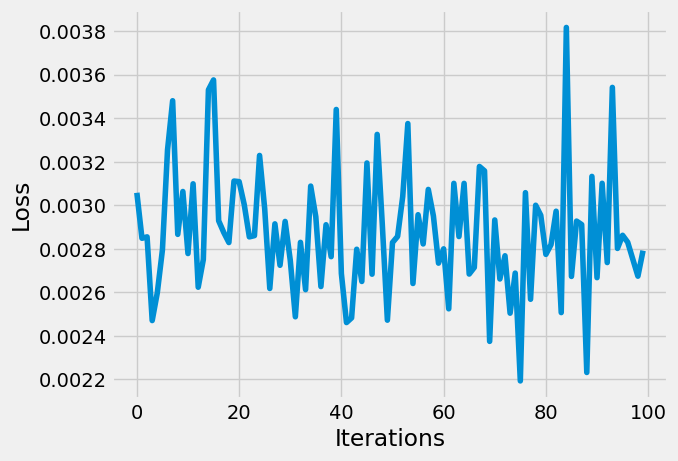

In [121]:
 # Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(loss[-100:])

Text(0.5, 1.0, 'reconstructed image')

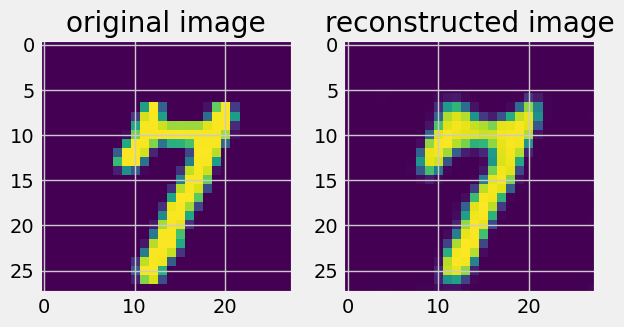

In [125]:
fig, ax = plt.subplots(1, 2)

_,image,recon = outputs[0]
image = image.reshape(-1, 28, 28)
ax[0].imshow(image[1].detach().cpu())
ax[0].set_title('original image')
recon = recon.reshape(-1, 28, 28)
ax[1].imshow(recon[1].detach().cpu())
ax[1].set_title('reconstructed image')